<a href="https://colab.research.google.com/github/katyamineeva/person-detection-from-aerial-drone/blob/master/models_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing models on synthetic datasets

Note that this notebook is adapted to Google.Colab usege.

## Loading required libs, modules, models and datasets


In [0]:
import os
import sys
import random
import math
import numpy as np
from numpy.random import randint
import skimage.io
from skimage import img_as_float, img_as_uint, img_as_int
import matplotlib
import matplotlib.pyplot as plt
from keras.utils import plot_model
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
import pickle
import shutil
from IPython.display import clear_output
import csv
import cv2
import keras
import tensorflow as tf
%load_ext autoreload
%autoreload 2

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
!pip install keras-resnet

###Local modules loading

In [0]:
sys.path.append('/content/drive/My Drive/project/')

from metrics import _init_paths
from metrics.lib.utils import *
from metrics.lib.BoundingBox import *
from metrics.lib.BoundingBoxes import *
from metrics.lib.Evaluator import *

from utils_main_project.local_paths import *
from utils_main_project.saving_loading import *
from utils_main_project.visualization import *
from utils_main_project.global_constants import *

sys.path.append(paths['mask-rcnn-tf'])
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.utils import extract_bboxes
from samples.coco import coco

sys.path.append(paths['retinanet-tf'])
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

### Functions for trained Mask R-CNN  and trained RetinaNet loading

In [0]:
def load_trained_mrcnn():        
    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1
        
    logs_dir = os.path.join(paths['mask-rcnn-tf'], 'logs')
    model = modellib.MaskRCNN(mode="inference", model_dir=logs_dir, config=InferenceConfig())
    
    weights_path = os.path.join(paths['mask-rcnn-tf'], 'mask_rcnn_coco.h5')
    model.load_weights(weights_path, by_name=True)
    return model

# Retinаnet
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

def load_trained_retinanet():
    keras.backend.tensorflow_backend.set_session(get_session())
    model_path = os.path.join(paths['retinanet-tf'], 'resnet50_coco_best_v2.1.0.h5')
    model = models.load_model(model_path, backbone_name='resnet50')
    # converting to inference mode
    # model = models.convert_model(model)
    return model

## Functions for model testing

In [0]:
def init_gt_bbox(id, bbox):
    [y, x, y2, x2] = bbox
    gt_bb = BoundingBox(imageName=str(id),
                        classId='person',
                        x=x, y=y, w=x2, h=y2,
                        typeCoordinates=CoordinatesType.Absolute,
                        bbType=BBType.GroundTruth,
                        format=BBFormat.XYX2Y2)
    return gt_bb

def init_dt_bbox(id, bbox, score):
    [y, x, y2, x2] = bbox
    dt_bb = BoundingBox(imageName=str(id),
                        classId='person',
                        x=x, y=y, w=x2, h=y2,
                        typeCoordinates=CoordinatesType.Absolute,
                        bbType=BBType.Detected,
                        classConfidence=score,
                        format=BBFormat.XYX2Y2)
    return dt_bb

In [0]:
def get_bboxes_mrcnn(dataset_path, display_progress=False, ids=None):
    model = load_trained_mrcnn()
    bb = BoundingBoxes()
    gt_bboxes = load_bboxes(dataset_path)
    
    if ids == None:
        ids = image_ids_list(dataset_path)
    
    
    for id, image_path in get_ids_n_images(dataset_path, return_val='paths', ids=ids):
        image = skimage.io.imread(image_path)

        # ground truth
        for bbox in gt_bboxes[id]:
            bb.addBoundingBox(init_gt_bbox(id, bbox))
            
        # detections
        r = model.detect([image])[0]
        
        dt_bboxes = extract_bboxes(r['masks'])
        for class_id, bbox, score in zip(r['class_ids'], dt_bboxes, r['scores']):
            if class_id == PERSON_CLASS_ID_COCO:
                bb.addBoundingBox(init_dt_bbox(id, bbox, score))
                
        if display_progress and id % 50 == 0:
            clear_output()
            print(id, "images processed")
    return bb


def get_bboxes_retinanet(dataset_path, display_progress=False, ids=None):
    model = load_trained_retinanet()
    bb = BoundingBoxes()
    gt_bboxes = load_bboxes(dataset_path)
    
    if ids == None:
        ids = image_ids_list(dataset_path)
    
    
    for id, image_path in get_ids_n_images(dataset_path, return_val='paths', ids=ids):        
        # ground truth
        for bbox in gt_bboxes[id]:
            bb.addBoundingBox(init_gt_bbox(id, bbox))

        #detected
        image = read_image_bgr(image_path)
        
        image = preprocess_image(image)
        image, scale = resize_image(image)
        bboxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
        bboxes /= scale

        for bbox, score, label in zip(bboxes[0], scores[0], labels[0]):
            if score < 0.5:
                break

            if label == PERSON_CLASS_ID_RETINANET:
                bbox = bbox.astype(int)
                bbox[0], bbox[1] = bbox[1], bbox[0]
                bbox[2], bbox[3] = bbox[3], bbox[2]
                bb.addBoundingBox(init_dt_bbox(id, bbox, score))
                
        if display_progress and id % 50 == 0:
            clear_output()
            print(id, "images processed")
    return bb                


def evaluate_model(bb, iou_tr=0.3, plot_pr_curve=False):
    eval = Evaluator()
    metrics = eval.GetPascalVOCMetrics(bb, IOUThreshold=iou_tr)[0]
    
    print("AP: ", metrics['AP'])
    print('total positives:', metrics['total positives'])
    print('total TP:', metrics['total TP'])
    print('total FP:', metrics['total FP'])
    
    if plot_pr_curve:
        eval.PlotPrecisionRecallCurve(bb, IOUThreshold=iou_tr,
                                      method=MethodAveragePrecision.EveryPointInterpolation, 
                                      showAP=True, showInterpolatedPrecision=True) 
    return metrics

## Mask R-CNN testing

### Testing Mask R-CNN on VisDrone synthetic data

800 images processed
AP:  0.5723131555459664
total positives: 1999
total TP: 1165.0
total FP: 92.0


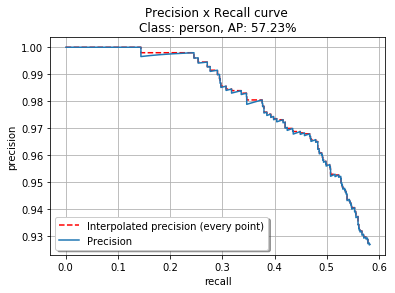

In [11]:
bb1 = get_bboxes_mrcnn(paths['visdrone_synthetic_images'], display_progress=True)
mc1 = evaluate_model(bb1, plot_pr_curve=True)
sAP1 = mc1['AP']

In [0]:
mc1 = evaluate_model(bb1, iou_tr=0.5)
sAP1 += mc1['AP']

AP:  0.5653206612094477
total positives: 1999
total TP: 1154.0
total FP: 103.0


In [0]:
mc1 = evaluate_model(bb1, iou_tr=0.75)
sAP1 += mc1['AP']
print('mAP:', sAP1 / 3)

AP:  0.43685759537329216
total positives: 1999
total TP: 981.0
total FP: 276.0
mAP: 0.5248304707095688


### Testing Mask R-CNN on MS COCO synthetic data

800 images processed
AP:  0.45474319927943857
total positives: 2013
total TP: 943.0
total FP: 91.0


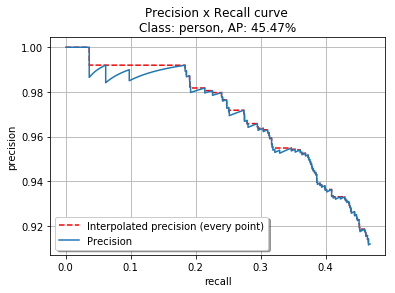

In [12]:
bb2 = get_bboxes_mrcnn(paths['coco_synthetic_images'], display_progress=True)
mc2 = evaluate_model(bb2, plot_pr_curve=True)
sAP2 = mc2['AP']

In [0]:
mc2 = evaluate_model(bb2, iou_tr=0.5)
sAP2 += mc2['AP']

AP:  0.4415293644765357
total positives: 2013
total TP: 923.0
total FP: 111.0


In [0]:
mc2 = evaluate_model(bb2, iou_tr=0.75)
sAP2 += mc2['AP']
print('mAP:', sAP2 / 3)

AP:  0.23321477325417903
total positives: 2013
total TP: 626.0
total FP: 408.0
mAP: 0.37649577900338443


## RetinaNet testing

### Testing RetinaNet on VisDrone synthetic data

800 images processed
AP:  0.387931039269159
total positives: 1999
total TP: 778.0
total FP: 4.0


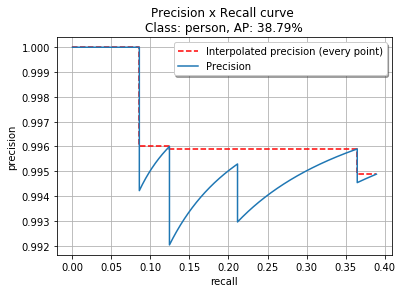

In [0]:
bb3 = get_bboxes_retinanet(paths['visdrone_synthetic_images'], display_progress=True)
mc3 = evaluate_model(bb3, plot_pr_curve=True)
sAP3 = mc3['AP']

In [0]:
mc3 = evaluate_model(bb3, iou_tr=0.5)
sAP3 += mc3['AP']

AP:  0.387931039269159
total positives: 1999
total TP: 778.0
total FP: 4.0


In [0]:
mc3 = evaluate_model(bb3, iou_tr=0.75)
sAP3 += mc3['AP']
print('mAP:', sAP3 / 3)

AP:  0.3472347926578187
total positives: 1999
total TP: 729.0
total FP: 53.0
mAP: 0.37436562373204557


### Testing RetinaNet on MS COCO synthetic data

800 images processed
AP:  0.27932247462299314
total positives: 2013
total TP: 566.0
total FP: 5.0


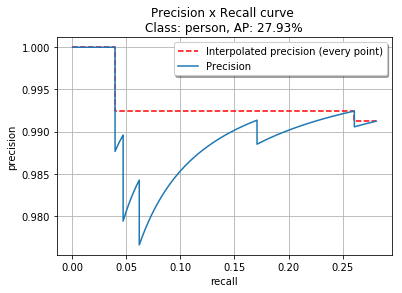

In [10]:
bb4 = get_bboxes_retinanet(paths['coco_synthetic_images'], display_progress=True)
mc4 = evaluate_model(bb4, plot_pr_curve=True)
sAP4 = mc4['AP']

In [8]:
mc4 = evaluate_model(bb4, iou_tr=0.5)
sAP4 += mc4['AP']

AP:  0.2774450667751727
total positives: 2013
total TP: 564.0
total FP: 7.0


In [9]:
mc4 = evaluate_model(bb4, iou_tr=0.75)
sAP4 += mc4['AP']
print('mAP:', sAP4 / 3)

AP:  0.21920815161469642
total positives: 2013
total TP: 492.0
total FP: 79.0
mAP: 0.25865856433762074
